In [64]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import distance as dist
import imutils


In [65]:
from skimage.util import img_as_float
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure


In [66]:
from pathlib import Path
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
from skimage.transform import resize

In [67]:
def auto_canny(image, sigma=0.33):
    
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    
    # return the edged image
    return edged

In [68]:
def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [69]:
def four_point_transform(image, pts):
    
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
  
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    return warped

In [70]:
def preprocess(image):
    #image = cv2.imread('train_image/4/30.jpg')
    ratio = image.shape[0] / 500.0
    orig = image.copy()
    image = imutils.resize(image, height = 500)


    # convert the image to grayscale, blur it, and find edges
    # in the image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    edged = auto_canny(gray)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    """plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(edged,cmap='gray')
    print(image.shape)"""
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

    # loop over the contours
    flag=0
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            flag=1
            break

        # show the contour (outline) of the piece of paper
    if flag!=0:
        print("STEP 2: Find contours of paper")
        im=cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
        
        #plt.imshow(im)
        
        warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

        # show the original and scanned images
        print("STEP 3: Apply perspective transform")
        #orig=imutils.resize(orig, height = 650)
        #warped=imutils.resize(warped, height = 650)
        orig=cv2.resize(orig, (500, 500),interpolation = cv2.INTER_NEAREST) 
        warped=cv2.resize(warped, (500, 500),interpolation = cv2.INTER_NEAREST) 

        """plt.figure(figsize=(12,12))
        plt.subplot(1,2,1)
        plt.imshow(orig)
        plt.subplot(1,2,2)
        plt.imshow(warped)
        print(warped.shape)"""
        
        return warped
    
    else:
        return orig


In [71]:
def feature_extraction(image):
    warped=preprocess(image)
    feature = []
    
    #ORB
    orb = cv2.ORB_create(nfeatures=3000)
    image_train=cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
    kp_logo, des_logo = orb.detectAndCompute(image_train, None)
    result_image_train = cv2.drawKeypoints(image_train, kp_logo, None, flags=0)
    
    """"plt.figure(figsize=(9,9))
    plt.imshow(result_image_train,cmap='gray')"""
    
    desc=des_logo
    desc=img_as_float(desc)
    d=desc.flatten()
    feature.append(d)
    
    #HOG
    resized_img = resize(warped, (256,512)) 
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 
    
    """"plt.imshow(hog_image,cmap='gray')"""
        
    feature.append(fd)
    
    
    return d,fd



In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [43]:
def load_image_files(container_path):
    """
    Load image files with categories as subfolder names 
    which performs like scikit-learn sample dataset
    
    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    dimension : tuple
        size to which image are adjusted to
        
    Returns
    -------
    Bunch
    """
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            d,fd=feature_extraction()
            F=np.concatenate([d,fd])
            flat_data.append(F) 
            #flat_data.append(img.flatten()) 
            #images.append(img_resized)
            #images.append(img)
            target.append(int(direc.name))
    flat_data = np.array(flat_data)
    flat_data = scaler.fit_transform(flat_data)
    target = np.array(target)
    #images2 = np.array(images)

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 #images=images2,
                 #list_im=images,
                 DESCR=descr)

In [44]:
image_dataset = load_image_files("train_image/")

STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective transform
STEP 2: Find contours of paper
STEP 3: Apply perspective trans

In [45]:
print(image_dataset.target.shape)

(57,)


In [46]:
print(image_dataset.data.shape)

(57, 157828)


In [47]:
image_data = image_dataset.data
labels = image_dataset.target

In [48]:
import random 
combined = list(zip(image_data, labels))
random.shuffle(combined)

image_data[:], labels[:] = zip(*combined)

In [49]:
print(image_data.shape)
print(labels.shape)

(57, 157828)
(57,)


In [50]:
number_of_classes = len(np.unique(labels))

In [51]:
def classWiseData(x, y):
    data = {}
    
    for i in range(number_of_classes):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [52]:
data = classWiseData(image_data, labels)

In [53]:
print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
print(data[3].shape[0])
print(data[4].shape[0])
print(data[5].shape[0])
print(data[6].shape[0])


7
8
11
14
7
7
3


In [54]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        
        #Training from here...
        # Weight and Bias update rule
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

In [55]:
"""Combines data of two classes into a single matrix"""
def getDataPairForSVM(d1,d2):
    
    l1,l2 = d1.shape[0], d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair, data_labels

array([[0., 0., 0., ..., 0., 0., 0.]])

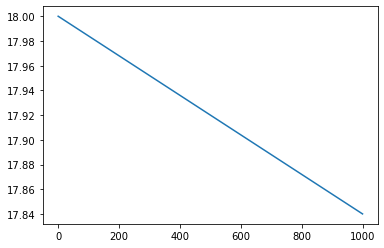

In [61]:
mySVM = SVM()
xp, yp = getDataPairForSVM(data[0], data[2])
w,b,loss = mySVM.fit(xp,yp,learning_rate=0.00001,maxItr=1000)
plt.plot(loss)
w

In [62]:
def trainSVMs(x,y):
    svm_classifiers = {}
    
    for i in range(number_of_classes):
        svm_classifiers[i] = {}
        for j in range(i+1, number_of_classes):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair, ypair,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    return svm_classifiers

In [63]:
svm_classifiers = trainSVMs(image_data, labels)

KeyboardInterrupt: 